In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from zamboni.models.simplenn import SimpleNN, EmbeddingNN
import matplotlib.pyplot as plt

In [2]:
# Custom Dataset class to handle parquet data
class ZamboniDataset(Dataset):
    def __init__(self, data, target_column, cat_features=None):
        self.feature_data = data.drop(columns=[target_column])
        self.features = self.feature_data.values
        self.cont_features = self.feature_data.drop(columns=cat_features).values
        self.cat_features = data[cat_features].values
        self.labels = data[target_column].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.cont_features[idx], dtype=torch.float32)
        x_cat = torch.tensor(self.cat_features[idx], dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.cat_features is not None:
            return x_cont, x_cat, y
        else:
            return x_cont, y

In [3]:
# Load parquet file into a Pandas DataFrame
data = pd.read_parquet('~/Code/zamboni/data/games.parquet')
data = data[data['homeTeamID'] != -1]
data = data[data['awayTeamID'] != -1]

In [4]:
# Define target column name
all_columns = data.columns.tolist()
target_column = 'outcome'
categorical_columns = ['homeTeamID', 'awayTeamID']
noscale_columns = [target_column] + categorical_columns
#scale_columns = all_columns - noscale_columns

In [5]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
num_teams = int(train_data['homeTeamID'].nunique()) + 5

In [10]:
# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_data.drop(columns=noscale_columns))
test_features = scaler.transform(test_data.drop(columns=noscale_columns))
#train_features = train_data.drop(columns=noscale_columns)
#test_features = test_data.drop(columns=noscale_columns)

# Recreate the train and test DataFrames with scaled features
train_data_scaled = pd.DataFrame(train_features)
test_data_scaled = pd.DataFrame(test_features)
for column in noscale_columns:
    train_data_scaled[column] = train_data[column].values
    test_data_scaled[column] = test_data[column].values

# Create Dataset objects
train_dataset = ZamboniDataset(train_data_scaled, target_column, categorical_columns) 
print(len(train_dataset))
test_dataset = ZamboniDataset(test_data_scaled, target_column, categorical_columns)
print(len(test_dataset))

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model, loss function, and optimizer
input_size = train_data.shape[1] - 1
#input_size = 9
print('input_size: ',input_size)
hidden_size = 128
num_classes = len(data[target_column].unique())
num_embed_features = 2 # Embedding each team
num_embed_categories = num_teams
embed_dim = 10
#model = SimpleNN(input_size, hidden_size, num_classes)
model = EmbeddingNN(input_size, hidden_size, num_classes, num_embed_features, num_embed_categories, embed_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

4702
1176
input_size:  11


In [11]:
criterion = nn.CrossEntropyLoss()

train_loss = []
test_loss = []

# Initial loss values
running_loss = 0
for inputs, cat_inputs, labels in train_loader:
    outputs = model(inputs, cat_inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
train_loss += [running_loss]
running_loss = 0
for inputs, cat_inputs, labels in test_loader:
    outputs = model(inputs, cat_inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
test_loss += [running_loss]

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, cat_inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs, cat_inputs)
        #outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss += [running_loss]

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, cat_inputs, labels in test_loader:
            outputs = model(inputs, cat_inputs)
            #test_outputs = model(test_inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
        test_loss += [running_test_loss]
    
    print(f'Epoch [{epoch+1}/{epochs}], Train loss: {running_loss/len(train_dataset):.4f}, Test loss: {running_test_loss/len(test_dataset):.4f}')

train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
train_loss /= len(train_dataset)
test_loss /= len(test_dataset)

Epoch [1/50], Train loss: 0.0226, Test loss: 0.0225
Epoch [2/50], Train loss: 0.0225, Test loss: 0.0225
Epoch [3/50], Train loss: 0.0224, Test loss: 0.0224
Epoch [4/50], Train loss: 0.0223, Test loss: 0.0223
Epoch [5/50], Train loss: 0.0222, Test loss: 0.0222
Epoch [6/50], Train loss: 0.0221, Test loss: 0.0222
Epoch [7/50], Train loss: 0.0221, Test loss: 0.0221
Epoch [8/50], Train loss: 0.0220, Test loss: 0.0220
Epoch [9/50], Train loss: 0.0219, Test loss: 0.0220
Epoch [10/50], Train loss: 0.0219, Test loss: 0.0219
Epoch [11/50], Train loss: 0.0218, Test loss: 0.0219
Epoch [12/50], Train loss: 0.0217, Test loss: 0.0218
Epoch [13/50], Train loss: 0.0217, Test loss: 0.0218
Epoch [14/50], Train loss: 0.0216, Test loss: 0.0218
Epoch [15/50], Train loss: 0.0216, Test loss: 0.0217
Epoch [16/50], Train loss: 0.0216, Test loss: 0.0217
Epoch [17/50], Train loss: 0.0215, Test loss: 0.0217
Epoch [18/50], Train loss: 0.0215, Test loss: 0.0216
Epoch [19/50], Train loss: 0.0214, Test loss: 0.0216
Ep

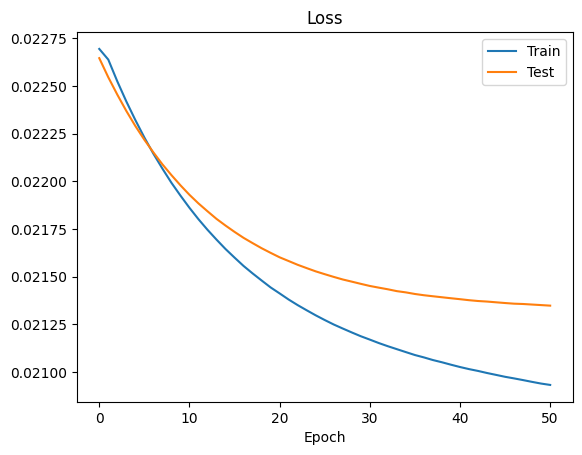

In [18]:
plt.plot(range(epochs+1), train_loss, label='Train')
plt.plot(range(epochs+1), test_loss, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
model.eval()
nored_criterion = nn.CrossEntropyLoss(reduction='none')
criterion = nn.CrossEntropyLoss()

train_labels = []
train_outputs = []
train_losses = []
train_corr = 0
test_labels = []
test_outputs = []
test_losses = []
test_corr = 0

running_loss = 0
for inputs, cat_inputs, labels in train_loader:
    outputs = model(inputs, cat_inputs)
    man_outputs = torch.argmax(outputs.softmax(dim=1), dim=1)
    nored_loss = nored_criterion(outputs, labels)
    loss = criterion(outputs, labels)
    nored_loss = nored_criterion(outputs, labels)
    train_corr += torch.sum(man_outputs == labels)
    running_loss += loss.item()
    train_labels += labels.tolist()
    train_outputs += man_outputs.tolist()
    train_losses += nored_loss.tolist()
print(f'Train loss: {running_loss / len(train_dataset)}')
print(f'Train accuracy: {train_corr / len(train_dataset)}')
print()
running_loss = 0
for inputs, cat_inputs, labels in test_loader:
    outputs = model(inputs, cat_inputs)
    man_outputs = torch.argmax(outputs.softmax(dim=1), dim=1)
    nored_loss = nored_criterion(outputs, labels)
    loss = criterion(outputs, labels)
    test_corr += torch.sum(man_outputs == labels)
    running_loss += loss.item()
    test_labels += labels.tolist()
    test_outputs += man_outputs.tolist()
    test_losses += nored_loss.tolist()
print(f'Test loss: {running_loss / len(test_dataset)}')
print(f'Test accuracy: {test_corr / len(test_dataset)}')

Train loss: 0.020925229924732145
Train accuracy: 0.5957039594650269

Test loss: 0.021348562066246864
Test accuracy: 0.5705782175064087


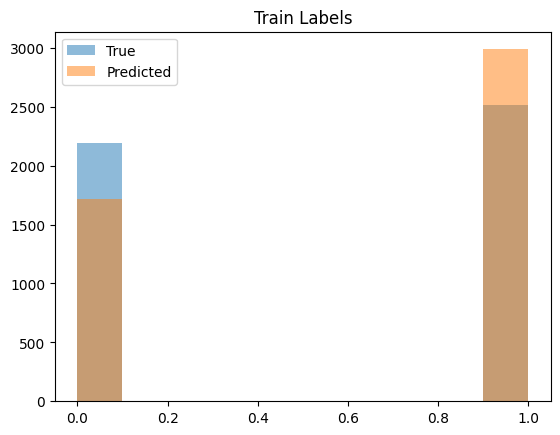

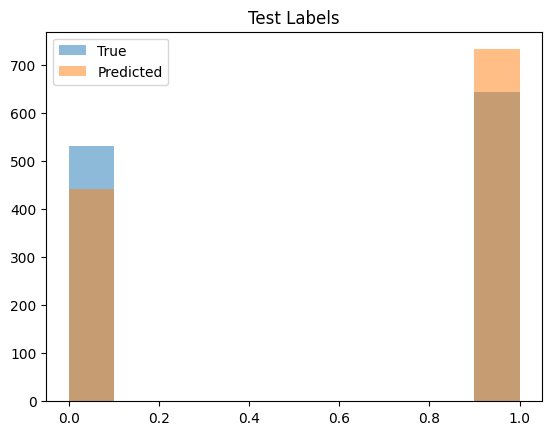

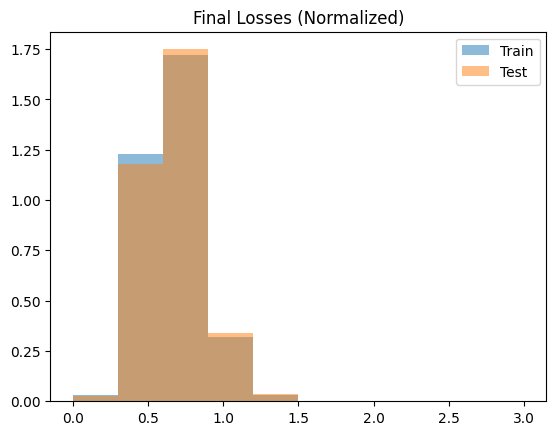

Training complete.


In [20]:
plt.hist(train_labels, alpha=0.5, label='True')
plt.hist(train_outputs, alpha=0.5, label='Predicted')
plt.title('Train Labels')
plt.legend()
plt.show()

plt.hist(test_labels, alpha=0.5, label='True')
plt.hist(test_outputs, alpha=0.5, label='Predicted')
plt.title('Test Labels')
plt.legend()
plt.show()

plt.hist(train_losses, alpha=0.5, label='Train', density=True, bins=10, range=[0,3])
plt.hist(test_losses, alpha=0.5, label='Test', density=True, bins=10, range=[0,3])
plt.title('Final Losses (Normalized)')
plt.legend()
plt.show()

#plt.savefig('tester.png')

print("Training complete.")